In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

In [3]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Check missing values
train.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

In [6]:
train_df = train.drop(["PoolQC", "MiscFeature", "Alley", "Fence", "Id"], axis=1)
test_df = test.drop(["PoolQC", "MiscFeature", "Alley", "Fence", "Id"], axis=1)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [8]:
X = train_df.drop('SalePrice', axis=1)
y = train_df[['SalePrice']]

In [9]:
num_col = [n for n in X.columns if X.dtypes[n] != 'object']
cat_col = [c for c in X.columns if X.dtypes[c] == 'object']

In [10]:
print(num_col, '\n', cat_col)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'] 
 ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Pa

In [11]:
imputer_col = SimpleImputer(strategy='most_frequent')
X[cat_col] = imputer_col.fit_transform(X[cat_col])

In [12]:
encoder = LabelEncoder()
X[cat_col] = X[cat_col].apply(encoder.fit_transform)

In [13]:
imputer_num = SimpleImputer(strategy='median')
X[num_col] = imputer_num.fit_transform(X[num_col])

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   float64
 1   MSZoning       1460 non-null   int64  
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   float64
 4   Street         1460 non-null   int64  
 5   LotShape       1460 non-null   int64  
 6   LandContour    1460 non-null   int64  
 7   Utilities      1460 non-null   int64  
 8   LotConfig      1460 non-null   int64  
 9   LandSlope      1460 non-null   int64  
 10  Neighborhood   1460 non-null   int64  
 11  Condition1     1460 non-null   int64  
 12  Condition2     1460 non-null   int64  
 13  BldgType       1460 non-null   int64  
 14  HouseStyle     1460 non-null   int64  
 15  OverallQual    1460 non-null   float64
 16  OverallCond    1460 non-null   float64
 17  YearBuilt      1460 non-null   float64
 18  YearRemo

In [15]:
X = X.values
y = y.values

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=101)

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_valid)

print('Accuray of Linear Regresion: {:.2f}%'.format(lr.score(X_valid, y_valid)*100))
print('RMSE of Linear Regression: {:.2f}'.format(mean_squared_error(y_valid, pred_lr, squared=False)))

Accuray of Linear Regresion: 59.04%
RMSE of Linear Regression: 49381.32


In [18]:
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_valid)

print('Accuray of Ridge Regresion: {:.2f}%'.format(ridge.score(X_valid, y_valid)*100))
print('RMSE of Ridge Regression: {:.2f}'.format(mean_squared_error(y_valid, pred_ridge, squared=False)))

Accuray of Ridge Regresion: 59.05%
RMSE of Ridge Regression: 49374.04


In [19]:
poly_feat = PolynomialFeatures(degree=2)
poly_feat.fit_transform(X_train)
poly_feat.transform(X_valid)
poly = LinearRegression().fit(X_train, y_train)
pred_poly2 = poly.predict(X_valid)

print('Accuray of 2nd degree Polynomial Regresion: {:.2f}%'.format(poly.score(X_valid, y_valid)*100))
print('RMSE of 2nd degree Polynomial Regression: {:.2f}'.format(mean_squared_error(y_valid, pred_poly2, squared=False)))

Accuray of 2nd degree Polynomial Regresion: 59.04%
RMSE of 2nd degree Polynomial Regression: 49381.32


In [20]:
poly_feat = PolynomialFeatures(degree=3)
poly_feat.fit_transform(X_train)
poly_feat.transform(X_valid)
poly = LinearRegression().fit(X_train, y_train)
pred_poly3 = poly.predict(X_valid)

print('Accuray of 3rd degree Polynomial Regresion: {:.2f}%'.format(poly.score(X_valid, y_valid)*100))
print('RMSE of 3rd degree Polynomial Regression: {:.2f}'.format(mean_squared_error(y_valid, pred_poly3, squared=False)))

Accuray of 3rd degree Polynomial Regresion: 59.04%
RMSE of 3rd degree Polynomial Regression: 49381.32


In [21]:
knr = KNeighborsRegressor(n_neighbors=1)
knr.fit(X_train, y_train)
pred_knr = knr.predict(X_valid)

print('Accuray of KNRegresion: {:.2f}%'.format(knr.score(X_valid, y_valid)*100))
print('RMSE of KNRegression: {:.2f}'.format(mean_squared_error(y_valid, pred_knr, squared=False)))

Accuray of KNRegresion: 58.05%
RMSE of KNRegression: 49971.55


Maximum score of n is: 3


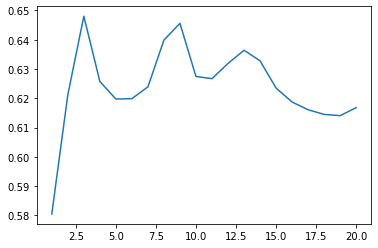

In [22]:
score_lst = []

for i in range(20):
    knr2 = KNeighborsRegressor(n_neighbors=(i+1))
    knr2.fit(X_train, y_train)
    score = knr2.score(X_valid, y_valid)
    score_lst.append(score)
    
plt.plot(range(1,21), score_lst)
print("Maximum score of n is:", pd.Series(score_lst).idxmax()+1)

In [23]:
max_n = pd.Series(score_lst).idxmax()+1

In [24]:
knr = KNeighborsRegressor(n_neighbors=max_n)
knr.fit(X_train, y_train)
pred_knr = knr.predict(X_valid)

print('Accuray of KNRegresion: {:.2f}%'.format(knr.score(X_valid, y_valid)*100))
print('RMSE of KNRegression: {:.2f}'.format(mean_squared_error(y_valid, pred_knr, squared=False)))

Accuray of KNRegresion: 64.79%
RMSE of KNRegression: 45779.84


In [25]:
svr = SVR(kernel = 'linear')
svr.fit(X_train, y_train.ravel())
pred_svr = svr.predict(X_valid)

print('Accuray of SVRegresion: {:.2f}%'.format(svr.score(X_valid, y_valid)*100))
print('RMSE of SVRegression: {:.2f}'.format(mean_squared_error(y_valid, pred_svr, squared=False)))

Accuray of SVRegresion: 53.48%
RMSE of SVRegression: 52624.49


In [26]:
# param = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'), 
#          'C' : [0.1, 1, 100, 1000], 
#          'degree' : [2, 3, 4, 5], 
#          'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5],
#          'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
#          'coef0' : [0.01, 0.1, 1, 10], 
#          'gamma' : ('auto', 'scale')}

# clf = GridSearchCV(SVR(), param)
# clf.fit(X_train, y_train.ravel())

In [27]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
pred_dtr = dtr.predict(X_valid)

print('Accuray of DTRegresion: {:.2f}%'.format(dtr.score(X_valid, y_valid)*100))
print('RMSE of DTRegression: {:.2f}'.format(mean_squared_error(y_valid, pred_dtr, squared=False)))

Accuray of DTRegresion: 80.92%
RMSE of DTRegression: 33702.37


In [28]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train.ravel())
pred_rfr = rfr.predict(X_valid)

print('Accuray of RFRegresion: {:.2f}%'.format(rfr.score(X_valid, y_valid)*100))
print('RMSE of RFRegression: {:.2f}'.format(mean_squared_error(y_valid, pred_rfr, squared=False)))

Accuray of RFRegresion: 80.80%
RMSE of RFRegression: 33810.37


Maximum score of n is: 700


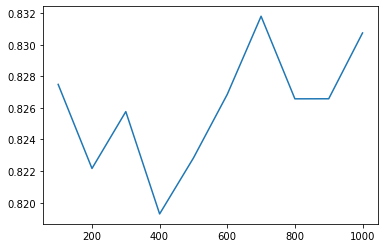

In [29]:
score_lst = []

for i in np.linspace(100, 1000, 10, dtype=int):
    rfr2 = RandomForestRegressor(n_estimators=i)
    rfr2.fit(X_train, y_train.ravel())
    score = rfr2.score(X_valid, y_valid)
    score_lst.append(score)
    
plt.plot(np.linspace(100, 1000, 10, dtype=int), score_lst)
print("Maximum score of n is:", (pd.Series(score_lst).idxmax()+1)*100)

In [30]:
max_est = (pd.Series(score_lst).idxmax()+1)*100

In [31]:
rfr = RandomForestRegressor(n_estimators=max_est)
rfr.fit(X_train, y_train.ravel())
pred_rfr = rfr.predict(X_valid)

print('Accuray of RFRegresion: {:.2f}%'.format(rfr.score(X_valid, y_valid)*100))
print('RMSE of RFRegression: {:.2f}'.format(mean_squared_error(y_valid, pred_rfr, squared=False)))

Accuray of RFRegresion: 82.71%
RMSE of RFRegression: 32084.35


In [32]:
xgbr = XGBRegressor(n_estimators = 1000, learning_rate = 0.1, seed = 101)
xgbr.fit(X_train, y_train)
pred_xgbr = xgbr.predict(X_valid)

print('Accuray of XGBRegresion: {:.2f}%'.format(xgbr.score(X_valid, y_valid)*100))
print('RMSE of XGBRegression: {:.2f}'.format(mean_squared_error(y_valid, pred_xgbr, squared=False)))

Accuray of XGBRegresion: 87.13%
RMSE of XGBRegression: 27674.78


In [33]:
# for tuning parameters
# parameters_for_testing = {
#    'colsample_bytree':[0.4, 0.6, 0.8],
#    'gamma':[0, 0.01, 0.1, 1],
#    'min_child_weight':[1.5, 6, 10],
#    'learning_rate':[0.01, 0.1],
#    'max_depth':[3, 5],
#    'n_estimators':[1, 10, 100, 1000],
#    'reg_alpha':[1e-5, 1e-2,  0.75],
#    'reg_lambda':[1e-5, 1e-2, 0.45],
#    'subsample':[0.6, 0.95]  
# }

                    
# xgb_model = XGBRegressor(learning_rate =0.1, 
#                          n_estimators=10, 
#                          max_depth=5, 
#                          min_child_weight=1, 
#                          gamma=0, 
#                          subsample=0.8, 
#                          colsample_bytree=0.8, 
#                          nthread=6, 
#                          scale_pos_weight=1, 
#                          seed=101)

# gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
# gsearch1.fit(X_train, y_train)

In [34]:
# print('best params')
# print (gsearch1.best_params_)
# print('best score')
# print (gsearch1.best_score_)

In [35]:
X_test = test_df
X_test[cat_col] = imputer_col.fit_transform(X_test[cat_col])
X_test[cat_col] = X_test[cat_col].apply(encoder.fit_transform)
X_test[num_col] = imputer_num.fit_transform(X_test[num_col])
X_test = X_test.values

In [36]:
pred_test = xgbr.predict(X_test)

In [37]:
pred_test

array([120946.06, 156992.47, 179046.16, ..., 169128.84, 112172.57,
       217928.38], dtype=float32)